# Example PVPRO run with synthetic data

This notebook generates a PV dataset from an NSRDB weather data file. The dataset is generated by specifying rates of change of single diode model parameters, so the ground truth is known. The simulation adds noise to the measured module temperature and plane-of-array irradiance in order to make a more realistic dataset.

Using the sythetic data, the PVPRO method is used to extract single diode model parameters vs. time. The results are compared to the ground truth.

## Imports

In [105]:
import numpy as np
import pandas as pd
import sys
import os

import inspect
import pvpro

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from pvlib.temperature import sapm_module, sapm_cell
from pvpro.main import PvProHandler, pvlib_single_diode
from pvpro.preprocess import Preprocessor
from pvpro.plotting import PvProPlot

## Generate Synthetic Data

### Load environmental data

In [106]:
data = np.load('./examples/data/NSRDB_data_compressed_123796_37.89_-122.26.npz')

### Process environmental data

In [107]:
df = pd.DataFrame({'dni': data['dni'],
                   'ghi': data['ghi'],
                   'temperature_air': data['temp_air'],
                   'wind_speed': data['wind_speed'],
                   'year': data['year'],
                   'month': data['month'],
                   'day': data['day'],
                   'hour': data['hour'],
                   'minute': data['minute']
                   })

df.index = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute']])

# Clip shorter
df = df[:'2002-01-01']

# 15 minute interpolation
df = df.resample('15T').interpolate('linear')

# drop times when GHI is <= 1
df.drop(df.index[df['ghi'] <= 1.], inplace=True)

# assume poa = ghi, e.g., horizontal module
df['poa_actual'] = df['ghi']

# Calculate true module/cell temperature
df['temperature_module_actual'] = sapm_module(
    poa_global=df['poa_actual'],
    temp_air=df['temperature_air'],
    wind_speed=df['wind_speed'],
    a=-3.56,
    b=-0.075
)

df['temperature_cell_actual'] = sapm_cell(
    poa_global=df['poa_actual'],
    temp_air=df['temperature_air'],
    wind_speed=df['wind_speed'],
    a=-3.56,
    b=-0.075,
    deltaT=3)

### Add simulated noise (optional)

In [108]:
# Simulate some noise on the "measured" poa irradiance by multiplying Gaussian noise with the "actual" poa irradiance.
# Fractional POA noise standard deviation. 
poa_noise_level = 0

# Seed random generator to get same results each time.
np.random.seed(0)
df['poa_meas'] = df['poa_actual'] * np.random.normal(1, poa_noise_level, len(df))


In [109]:
# The "measured" module temperature is created by adding normally distributed noise to the "actual" module temperature.
# Temperature noise standard deviation in C.
temperature_noise_level = 0.1

df['temperature_module_meas'] = df['temperature_module_actual'] + \
        np.random.normal(0,temperature_noise_level, len(df))


### Set the parameters and how they change with time.

In [110]:
def step_change(start_val, end_val, t_years, t_step=2):
    """
    Create a smooth step change time series. 
    """
    y = np.zeros_like(t_years) + start_val
    y = y + (end_val - start_val) * (
            np.arctan(10 * (t_years - 2)) / np.pi + 0.5)
    return y

In [111]:
q = 1.60218e-19  # Elementary charge in units of coulombs
kb = 1.38066e-23  # Boltzmann's constant in units of J/K

# time vector in years
t_years = (df.index - df.index[0]).days / 365

df['cells_in_series'] = 60
df['alpha_sc'] = 0.001
df['diode_factor'] = 1.2 - 0.0 * t_years
df['nNsVth_ref'] = df['diode_factor'] * df['cells_in_series'] * kb / q * (
        273.15 + 25)
df['photocurrent_ref'] = 6.0 - (0.05 * t_years - 0.025 * np.sin(2 * np.pi * t_years))
df['saturation_current_ref'] = 1e-10 + 0.1e-10 * t_years
df['resistance_shunt_ref'] = 600 - 10*t_years
df['conductance_shunt_extra'] = 0.0
df['resistance_series_ref'] = 0.35 + 0.02 * t_years


### Calculate operation data over time

In [112]:
out = pvlib_single_diode(
    effective_irradiance=df['poa_actual'],
    temperature_cell=df['temperature_cell_actual'],
    resistance_shunt_ref=df['resistance_shunt_ref'],
    resistance_series_ref=df['resistance_series_ref'],
    diode_factor=df['diode_factor'],
    cells_in_series=df['cells_in_series'],
    alpha_isc=df['alpha_sc'],
    photocurrent_ref=df['photocurrent_ref'],
    saturation_current_ref=df['saturation_current_ref'],
    technology = 'mono-Si',
    conductance_shunt_extra=df['conductance_shunt_extra'],
    singlediode_method='lambertw', #'newton',
)

# Add to the dataframe
for k in out.keys():
    df[k] = out[k]

# Calculate module reference conditions over time.
out_ref = pvlib_single_diode(
    effective_irradiance=1000,
    temperature_cell=25,
    resistance_shunt_ref=df['resistance_shunt_ref'],
    resistance_series_ref=df['resistance_series_ref'],
    diode_factor=df['diode_factor'],
    cells_in_series=df['cells_in_series'],
    alpha_isc=df['alpha_sc'],
    photocurrent_ref=df['photocurrent_ref'],
    saturation_current_ref=df['saturation_current_ref'],
    conductance_shunt_extra=df['conductance_shunt_extra'],
    singlediode_method='newton',
    technology = 'mono-Si'
)

for k in out_ref.keys():
    df[k + '_ref'] = out_ref[k]

# Set DC operation point at MPP
df['v_dc'] = df['v_mp']
df['i_dc'] = df['i_mp']

# Change DC operation point to Voc during low irradiance conditions
df.loc[df['poa_actual'] < 50, 'v_dc'] = df.loc[
    df['poa_actual'] < 50, 'v_oc']
df.loc[df['poa_actual'] < 50, 'i_dc'] = 0

df.loc[df.index.day==1, 'v_dc'] = df.loc[df.index.day==1, 'v_oc']
df.loc[df.index.day==1, 'i_dc'] = 0

## Preprocess

In [113]:
pvproplot = PvProPlot(system_name='Synthetic dataset')

In [114]:
pre = Preprocessor(df,
                   voltage_dc_key='v_dc',
                   current_dc_key='i_dc',
                   temperature_module_key='temperature_module_meas',
                   irradiance_poa_key='poa_meas',
                   modules_per_string=1,
                   parallel_strings=1,
                   )

### Run preprocess pipeline

In [115]:
# Calculate cell temperature from module temperature and POA

pre.calculate_cell_temperature(delta_T=3)

# Two preprocessing modes, 'fast' and 'sdt'. Since this is clean synthetic data, we will use the 'fast' pipeline.

method='fast'
if method=='sdt':
    pre.run_preprocess_sdt(correct_dst=True)
    pre.classify_points_sdt()
    pre.build_operating_cls()

elif method=='fast':
    pre.classify_points_pva()
    pre.build_operating_cls()

Cell temperature assigned to 'temperature_cell'


## Parameter estimation

In [116]:
# Make PvProHandler object to store data and run analysi
pvp = PvProHandler(pre.df,
                   system_name='synthetic',
                   cells_in_series=60,
                   alpha_isc=0.001,
                   voltage_key='v_dc',
                   current_key='i_dc',
                   temperature_cell_key='temperature_cell',
                   irradiance_poa_key='poa_meas',
                   modules_per_string=1,
                   parallel_strings=1,
                   technology='mono-Si'
                   )

### Estimate startpoint

In [117]:
pvp.estimate_p0(
    boolean_mask = np.logical_and.reduce(
        (pvp.df['operating_cls']==0,
        pvp.df[pvp.irradiance_poa_key]>300)),
    technology='mono-Si'  
)

# Can set a custom startpoint if auto-chosen startpoint isn't great
pvp.p0['saturation_current_ref'] = 1e-10
pvp.p0['resistance_series_ref'] = 0.35

### Esitimation setting

In [118]:
# Set boolean mask for which points to include. For this clean data, we are choosing a very simple mask. 
# For a real PV dataset, more filtering on bad data is typically required.

boolean_mask = pvp.df['poa_meas'] > 100


# Set hyperparameters for running model

hyperparams = {
    'use_voc_points': False,
    'use_mpp_points': True,
    'use_clip_points': False,
    'method': 'minimize',
    'solver': 'L-BFGS-B',
    'days_per_run': 14,
    'iterations_per_year': 26,
    'verbose' : False,
    'saturation_current_multistart':[1.0],
    'start_point_method': 'last',
    'boolean_mask': boolean_mask,
    'singlediode_method':'fast'
}

# Choose the parameters to estimate

fit_params = ['photocurrent_ref', 'saturation_current_ref',
                          'resistance_series_ref', 
                         'resistance_shunt_ref', 
                          'diode_factor']

# Set the lower and upper bounds for parameters

lower_bounds = dict(
            diode_factor=1.2-1e-3,
            photocurrent_ref=0.01,
            saturation_current_ref=1e-12,
            resistance_series_ref=0,
            conductance_shunt_extra=0,
            resistance_shunt_ref=10
        )

upper_bounds = dict(
    diode_factor=1.2+1e-3,
    photocurrent_ref=10,
    saturation_current_ref=1e-7,
    resistance_series_ref=1,
    conductance_shunt_extra=0,
    resistance_shunt_ref=700
)

### Run estimation

In [119]:
ret = pvp.execute(iteration='all', fit_params= fit_params,
                lower_bounds=lower_bounds,
                upper_bounds=upper_bounds,
                  **hyperparams,
                  technology='mono-Si') 

100%|██████████| 104/104 [00:06<00:00, 15.69it/s]

Elapsed time: 0.11 min


## Post-processing and plot results

In [120]:
# Get results
pfit = pvp.result['p']

### Analyze year-on-year trend

In [121]:
yoy_result = pvp.analyze_yoy(pfit)

### Format ground truth data for comparison

In [122]:
compare = pvp.df.resample('M').mean()
compare['t_years'] = np.array(
            [t.year + (t.dayofyear - 1) / 365.25 for t in compare.index])

### Plot evolution trend of parameters

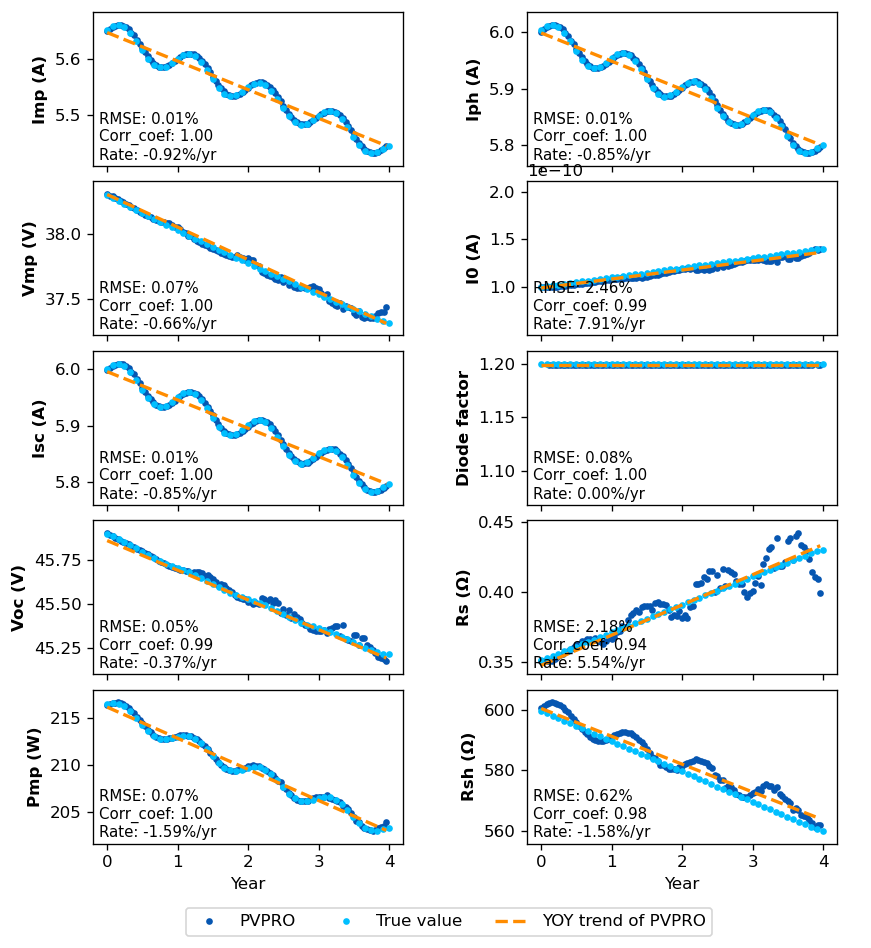

In [123]:

keys_show = ['i_mp_ref', 'photocurrent_ref',
                    'v_mp_ref', 'saturation_current_ref',
                    'i_sc_ref', 'diode_factor',
                    'v_oc_ref', 'resistance_series_ref',
                    'p_mp_ref', 'resistance_shunt_ref'
                    ]
                    
# remove amonaly value
for key in keys_show:
    para = pfit[key]
    inx = (para <np.mean(para)-3*np.std(para)) | (para >np.mean(para)+3*np.std(para))
    pfit[key][inx] = np.nan


# Plot estimated parameters vs time with error
error_df = pvproplot.plot_results_timeseries_error(pfit, df = df, 
                        yoy_result=yoy_result,
                        compare=compare,
                        cal_error_synthetic = True,
                        yoy_plot = True,
                        legendloc = [0.3, -0.6]
                        )
plt.gcf().set_dpi(120)
plt.show()
